# Clean Data
- Examine and modify datatypes - categorical, continuous, discrete.
- Drop irrelevant columns and rows.
- Detect patterns in nullish values.

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Check working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Ask pandas to display all columns
pd.set_option('display.max_columns', None)

Current Directory: /Users/yun/Documents/GLIMS/glims_notebooks


In [2]:
# Load Esri shapefiles as geopandas dataframes
polygons = gpd.read_file("GLIMS_20230716/glims_download_13173/glims_polygons.shp")

## Drop Non-Glacier Columns

Since the goal is to find glacier data stories, identify and drop variables related to glacier research (data submission, measurement uncertainties, etc.).

Variable definitions in the data documentation: [User Guide](https://nsidc.org/sites/default/files/nsidc-0272-v001-userguide_1.pdf) and the [GLIMS Description of fields](http://www.glims.org/MapsAndDocs/downloaded_field_desc.html).


In [3]:
polygons.dtypes

line_type       object
anlys_id       float64
glac_id         object
anlys_time      object
area           float64
db_area        float64
width          float64
length         float64
primeclass     float64
min_elev       float64
mean_elev      float64
max_elev       float64
src_date        object
rec_status      object
glac_name       object
wgms_id         object
local_id        object
glac_stat       object
subm_id        float64
release_dt      object
proc_desc       object
rc_id          float64
geog_area       object
chief_affl      object
loc_unc_x        int64
loc_unc_y        int64
glob_unc_x       int64
glob_unc_y       int64
submitters      object
analysts        object
geometry      geometry
dtype: object

Before dropping them, check these variables starting from the fewest unique values, which tend to be categorical. 
Plan treatment: modify datatype, subset, eliminate, etc.

Similar numbers of unique values reveal possible correlations for later consideration.
- loc_unc_y and loc_unc_x
- glob_unc_y and glob_unc_x
- glac_id and db_area
- geometry and anlys_id

In [4]:
# Number of unique values in each field
polygons.nunique().sort_values(ascending=True)

rec_status         1
glac_stat          3
line_type          6
primeclass        10
loc_unc_y         14
loc_unc_x         14
glob_unc_y        17
glob_unc_x        18
chief_affl        46
geog_area         49
rc_id             53
submitters        67
analysts         109
proc_desc        165
release_dt       278
width            293
anlys_time       456
subm_id          624
src_date        1178
length          6122
min_elev        6644
mean_elev       6691
max_elev        7409
wgms_id        17239
glac_name      35112
local_id       69166
area          125554
glac_id       328115
db_area       353842
geometry      530099
anlys_id      557884
dtype: int64

In [5]:
# REMOVE
# entries = "okay", as expected for downloaded data. 
polygons.rec_status.value_counts()

okay    565887
Name: rec_status, dtype: int64

In [6]:
# KEEP
# Most glaciers have status of "exists", a few are "gone". 
# Documentation does not mention "None" value. May be missing data. 
polygons.glac_stat.value_counts()

exists    560556
None        4993
gone         338
Name: glac_stat, dtype: int64

In [7]:
# KEEP
# Most polygons are glacier boundaries; others can be removed.
polygons.line_type.value_counts()

glac_bound     564112
debris_cov       1005
intrnl_rock       452
pro_lake          291
supra_lake         18
basin_bound         9
Name: line_type, dtype: int64

In [8]:
# KEEP
# Most primary classifications are "Other"
# https://wgms.ch/data_submission/
# https://wgms.ch/downloads/FoG_Submission_instructions.pdf
polygons.primeclass.value_counts()

0.0     538864
9.0       8151
7.0       7579
6.0       6850
5.0       1912
4.0       1581
3.0        598
10.0       205
2.0        146
8.0          1
Name: primeclass, dtype: int64

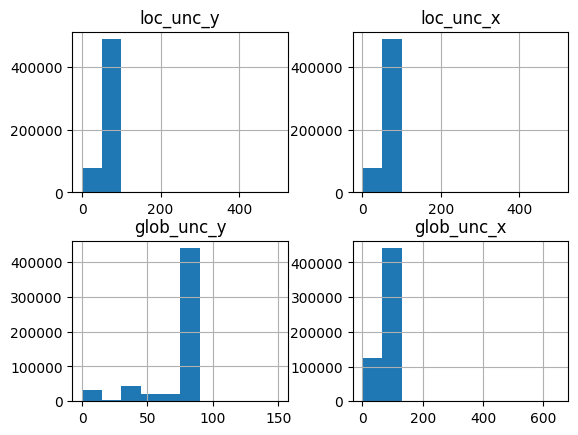

In [9]:
# REMOVE
# Positional uncertainty of vertices/polygon
# Focus on glacier story, not data quality story
polygons[['loc_unc_y','loc_unc_x','glob_unc_y','glob_unc_x']].hist();

In [10]:
# REMOVE
# Associated with regional centers
# similarities in value counts more than coincidental
set(polygons.chief_affl.value_counts()) & set(polygons.rc_id.value_counts())

{1,
 15,
 47,
 51,
 72,
 81,
 93,
 100,
 101,
 111,
 156,
 259,
 265,
 270,
 271,
 374,
 410,
 425,
 484,
 660,
 903,
 1367,
 1497,
 1896,
 2074,
 2605,
 2652,
 2795,
 3519,
 3581,
 3948,
 4972,
 5289,
 5390,
 6577,
 17555,
 19195,
 43383,
 48569,
 133414}

In [11]:
# REMOVE
# Also associated with regional centers
# Too much Umbrella and Various data 
polygons.geog_area.value_counts()

Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS    173527
Asia                                                                      133414
China                                                                      48569
Various (GlobGlacier)                                                      45079
Himalaya (India, Nepal, Bhutan)                                            43383
Swiss Alps                                                                 19979
Argentina                                                                  19195
Northern Cordillera                                                        17555
Caucausus Region                                                            6577
Siberian Mountains                                                          6094
Antarctic Peninsula                                                         5577
Austrian Alps                                                               5390
Conterminous USA            

In [12]:
# REMOVE
# names of researchers, 34% are both submitters and analysts
sum(polygons.submitters == polygons.analysts)/polygons.shape[0]

0.34126777960971005

In [13]:
# REMOVE
# long text descriptions
polygons.proc_desc.sample(5)

133761    Object-based semi-automated glacier classifica...
260146    Semi-automated glacier classification.; From R...
334677    ; The data on glacier location and change was ...
16010     Semi-automated glacier classification.; From R...
430663    Semi-automated glacier classification; Semi-au...
Name: proc_desc, dtype: object

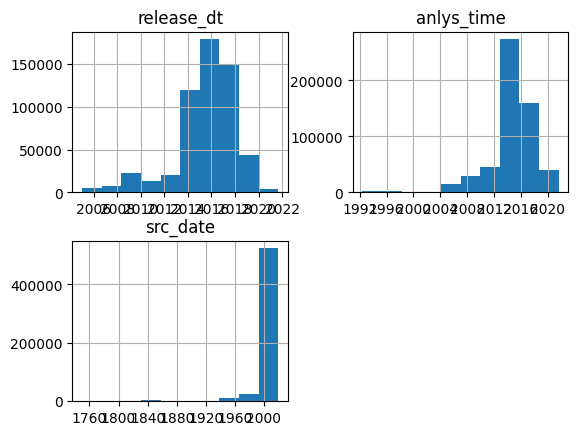

In [14]:
# KEEP 'anlys_time', 'src_date'
# REMOVE "release_dt". 
# temporal, no documentation on "release_dt". 
# Number of release_dt < anlys_time < src_date
polygons[['release_dt', 'anlys_time', 'src_date']] = polygons[['release_dt', 'anlys_time', 'src_date']].apply(pd.to_datetime)
polygons[['release_dt', 'anlys_time', 'src_date']].hist();

In [15]:
# REMOVE
# related to data provider
polygons.subm_id.value_counts()

698.0    133414
637.0     54397
583.0     42377
638.0     27861
624.0     27017
          ...  
309.0         1
173.0         1
162.0         1
179.0         1
722.0         1
Name: subm_id, Length: 624, dtype: int64

In [16]:
# KEEP glac names for fun
# REMOVE wgms and local
# Lots of "None"
polygons.wgms_id.value_counts(normalize=True) # 91% "None"
polygons.local_id.value_counts(normalize=True) # 65% "None"
polygons.glac_name.value_counts(normalize=True) # 76% "None"
sum(polygons.wgms_id=='None'), sum(polygons.local_id=='None'), sum(polygons.glac_name=='None')

(515127, 367393, 435161)

In [17]:
# Remove non-glacial columns
polygons1 = polygons.drop(labels=[
    'rec_status', 'wgms_id', 'local_id', 
    'subm_id', 'release_dt', 'proc_desc', 
    'rc_id', 'geog_area', 'chief_affl', 
    'loc_unc_x', 'loc_unc_y', 'glob_unc_x', 'glob_unc_y',
    'submitters', 'analysts'
], axis=1)

## Remove Non-Glacier Rows
Remove polygon features representing non-glacier boundaries.

In [18]:
# Most entities are glacier boundaries.
polygons1.line_type.value_counts()

glac_bound     564112
debris_cov       1005
intrnl_rock       452
pro_lake          291
supra_lake         18
basin_bound         9
Name: line_type, dtype: int64

In [19]:
# Remove non-glacier entities.
polygons2 = polygons1[polygons1.line_type=="glac_bound"]
#polygons2.line_type.value_counts()
polygons2.drop('line_type', axis=1, inplace=True)

/var/folders/13/hf_sfnls1lq6kn8vsc92q40h0000gn/T/ipykernel_43717/1093122923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygons2.drop('line_type', axis=1, inplace=True)


In [20]:
polygons2.dtypes

anlys_id             float64
glac_id               object
anlys_time    datetime64[ns]
area                 float64
db_area              float64
width                float64
length               float64
primeclass           float64
min_elev             float64
mean_elev            float64
max_elev             float64
src_date      datetime64[ns]
glac_name             object
glac_stat             object
geometry            geometry
dtype: object

In [21]:
# NaNs only for glac_name, which is ornamental, can address later
polygons2.isna().sum()

anlys_id       0
glac_id        0
anlys_time     0
area           0
db_area        0
width          0
length         0
primeclass     0
min_elev       0
mean_elev      0
max_elev       0
src_date       0
glac_name     12
glac_stat      0
geometry       0
dtype: int64

In [22]:
polygons2.sample(5)

,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,geometry
370969,386077.0,G243219E50714N,2008-05-01,4.535720,4.535700,0.0,0.0,0.0,0.0,0.0,0.0,2006-08-28,Bugaboo Glacier,exists,"POLYGON Z ((-116.78553 50.73418 0.00000, -116...."
276547,343119.0,G008548E46451N,1995-06-01,0.000005,0.041284,0.0,0.0,0.0,0.0,0.0,0.0,1973-09-01,None,exists,"POLYGON Z ((8.54653 46.45091 0.00000, 8.54654 ..."
559946,712393.0,G290842E82936N,2018-04-01,2.877970,2.880260,0.0,0.0,0.0,0.0,0.0,0.0,2009-07-30,None,exists,"POLYGON Z ((-69.16558 82.94549 0.00000, -69.15..."
520830,625815.0,G086202E28319N,2018-07-01,0.000000,3.169680,0.0,0.0,0.0,0.0,0.0,0.0,1998-06-11,Chaxiequdeng Glacier,exists,"POLYGON Z ((86.20079 28.30517 0.00000, 86.2006..."
221364,252265.0,G080326E35786N,2014-06-15,0.041183,0.041178,0.0,0.0,0.0,5733.0,5835.0,5917.0,2011-08-05,None,exists,"POLYGON Z ((80.32480 35.78711 0.00000, 80.3248..."


In [23]:
#polygons2.to_csv("GLIMS_20230716/polygons2.csv", index=False)